In [5]:
import numpy as np
import json
import random

In [6]:
with open('bigtom_filter.npy', 'rb') as f:
    bigtom_filter = np.load(f)
with open('opentom_filter.npy', 'rb') as f:
    opentom_filter = np.load(f)
with open('bigtom_runnable_filter.npy', 'rb') as f:
    bigtom_runnable_filter = np.load(f)
with open('opentom_runnable_filter.npy', 'rb') as f:
    opentom_runnable_filter = np.load(f)
    
from sklearn.metrics import classification_report

In [7]:
dataset = 'opentom'
task = 'task3'
model = 'deepseek-reasoner'
with open(f'{dataset}_{task}_ans_{model}.jsonl') as f: # put story here
        task_ans = np.array([json.loads(line) for line in f])
print(len(task_ans))
with open(f'{dataset}_task1_ans_{model}.jsonl') as f: # put story here
        IDs = np.array([json.loads(line)['ID'] for line in f])
filter = ''
if dataset == 'bigtom':
        filter = bigtom_filter
else:
        filter = opentom_filter 
IDs_after_filter = IDs[filter]
task3_ans = [instance for instance in task_ans if instance['ID'] in IDs_after_filter]
# print(len(task_ans[filter]))
print(len(task3_ans))

806
711


In [10]:
task3_ans[0]['sense']

'visual'

In [ ]:
senses = ['visual', 'auditory', 'olfactory', 'gustatory', 'tactile', 'proprio', 'social']
num_senses = len(senses)
sense_dict = {sense:i for i,sense in enumerate(senses)}

In [17]:
def return_metrics(dataset, model, task, mode = 'post', experiment = 'normal'): # task = task1, task2, task3, task4
    # mode = pre/post
    # experiment = normal/senses
    random.seed(0)
    np.random.seed(0)
    with open(f'{dataset}_{task}_ans_{model}.jsonl') as f: # put story here
        task_ans = np.array([json.loads(line) for line in f])
    if mode == 'post' and (task == 'task1' or task == 'task2'):
        if dataset == 'bigtom':
            if len(task_ans) == 1156:
                task_ans = task_ans[bigtom_filter]
            if len(task_ans) == 1068:
                task_ans = task_ans[bigtom_runnable_filter] # for experiment
        else:
            if len(task_ans) == 1326:
                task_ans = task_ans[opentom_filter]
            if len(task_ans) == 1223:
                task_ans = task_ans[opentom_runnable_filter] # for experiment
                
    # look at tasks
    if task == 'task1':
        task1_llm_answer = [instance['llm_answer'] for instance in task_ans]
        task1_true_answer = [np.array(['A', 'B'])[np.array(instance['true_answer'])] for instance in task_ans]
        # bigtom_task1_llm_answer = bigtom_task1_llm_answer[0:50]
        # bigtom_task1_true_answer = bigtom_task1_true_answer[0:50]
        task1_llm_answer = np.array(task1_llm_answer)
        task1_true_answer = np.array(task1_true_answer)
        
        if experiment == 'senses':
            converted_llm_answer_hard = {sense:[] for sense in senses}
            converted_true_answer_hard = {sense:[] for sense in senses}
            converted_llm_answer_total = {sense:[] for sense in senses}
            converted_true_answer_total = {sense:[] for sense in senses}
            converted_llm_answer_easy_only = {sense:[] for sense in senses}
            converted_true_answer_easy_only = {sense:[] for sense in senses}

        else:
            converted_llm_answer_hard = []
            converted_true_answer_hard = []
            converted_llm_answer_total = []
            converted_true_answer_total = []
            converted_llm_answer_easy_only = []
            converted_true_answer_easy_only = []


        # bigtom_task1_accuracy = (bigtom_task1_llm_answer == bigtom_task1_true_answer).mean(axis=1)
        # gt_id = {'positive':0, 'hard_negative': 1, 'easy_negative':2}
        # bigtom_task1_correct = np.zeros((100, 3, 8)) # groundtruth: pos, hard_neg, easy_neg
        # bigtom_task1_total = np.zeros((100, 3, 8))
        for idx, instance in enumerate(task_ans):
            if instance['groundtruth_classification'] == 'positive':
                for i in range(len(instance['llm_answer'])):
                    # insert to hard array
                    # llm_answer = instance['llm_answer'][i]
                    llm_correct = instance['llm_answer'][i] == np.array(['A', 'B'])[np.array(instance['true_answer'])][i]
                    if experiment == 'senses':
                        instance_sense = instance['sense']
                        if instance_sense == 'thermo':
                            instance_sense = 'tactile'
                        converted_true_answer_hard[instance_sense].append(1)
                        converted_llm_answer_hard[instance_sense].append(int(llm_correct))
                        converted_true_answer_total[instance_sense].append(1)
                        converted_llm_answer_total[instance_sense].append(int(llm_correct))
                        converted_true_answer_easy_only[instance_sense].append(1)
                        converted_llm_answer_easy_only[instance_sense].append(int(llm_correct))
                    else:
                        converted_true_answer_hard.append(1)
                        converted_llm_answer_hard.append(int(llm_correct))
                        converted_true_answer_total.append(1)
                        converted_llm_answer_total.append(int(llm_correct))
                        converted_true_answer_easy_only.append(1)
                        converted_llm_answer_easy_only.append(int(llm_correct))
            else: # negative
                for i in range(len(instance['llm_answer'])):
                    llm_correct = instance['llm_answer'][i] == np.array(['A', 'B'])[np.array(instance['true_answer'])][i]
                    if experiment == 'senses':
                        instance_sense = instance['sense']
                        if instance_sense == 'thermo':
                            instance_sense = 'tactile'
                        converted_true_answer_total[instance_sense].append(0)
                        converted_llm_answer_total[instance_sense].append(1-int(llm_correct))
                        if instance['groundtruth_classification'] == 'hard_negative':
                            converted_true_answer_hard[instance_sense].append(0)
                            converted_llm_answer_hard[instance_sense].append(1-int(llm_correct))
                        else:
                            converted_true_answer_easy_only[instance_sense].append(0)
                            converted_llm_answer_easy_only[instance_sense].append(1-int(llm_correct))
                    else:    
                        converted_true_answer_total.append(0)
                        converted_llm_answer_total.append(1-int(llm_correct))
                        if instance['groundtruth_classification'] == 'hard_negative':
                            converted_true_answer_hard.append(0)
                            converted_llm_answer_hard.append(1-int(llm_correct))
                        else:
                            converted_true_answer_easy_only.append(0)
                            converted_llm_answer_easy_only.append(1-int(llm_correct))

        if experiment == 'senses':
            return_dict = {}
            for sense in senses:
                hard_neg_only_report = classification_report(converted_true_answer_hard[sense],converted_llm_answer_hard[sense], digits = 3, output_dict = True)
                easy_neg_only_report = classification_report(converted_true_answer_easy_only[sense],converted_llm_answer_easy_only[sense], digits = 3, output_dict = True)
                all_neg_report = classification_report(converted_true_answer_total[sense],converted_llm_answer_total[sense], digits = 3, output_dict = True)
                return_dict_sense = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in hard_neg_only_report['0'].items() if k != 'support'}, 'Easy_Negative': {k: v for k,v in easy_neg_only_report['0'].items() if k != 'support'}},
                            'Combined': {'Positive_and_Hard_Neg_only':{'accuracy':hard_neg_only_report['accuracy'] if hard_neg_only_report['accuracy'] is not None else hard_neg_only_report['micro avg']['f1-score'], 'macro-f1' : hard_neg_only_report['macro avg']['f1-score']},
                                            'Total':{'accuracy':all_neg_report['accuracy'] if all_neg_report['accuracy'] is not None else all_neg_report['micro avg']['f1-score'], 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
                return_dict[sense] = return_dict_sense
        else:
            hard_neg_only_report = classification_report(converted_true_answer_hard,converted_llm_answer_hard, digits = 3, output_dict = True)
            easy_neg_only_report = classification_report(converted_true_answer_easy_only,converted_llm_answer_easy_only, digits = 3, output_dict = True)
            all_neg_report = classification_report(converted_true_answer_total,converted_llm_answer_total, digits = 3, output_dict = True)
            return_dict = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in hard_neg_only_report['0'].items() if k != 'support'}, 'Easy_Negative': {k: v for k,v in easy_neg_only_report['0'].items() if k != 'support'}},
                        'Combined': {'Positive_and_Hard_Neg_only':{'accuracy':hard_neg_only_report['accuracy'] if hard_neg_only_report['accuracy'] is not None else hard_neg_only_report['micro avg']['f1-score'], 'macro-f1' : hard_neg_only_report['macro avg']['f1-score']},
                                        'Total':{'accuracy':all_neg_report['accuracy'] if all_neg_report['accuracy'] is not None else all_neg_report['micro avg']['f1-score'], 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
        # print(json.dumps(return_dict, indent=4))
    elif task == 'task2':
        letters = {'A':0, 'B':1, 'C':2, 'D':3}

        task2_llm_answer = [instance['llm_answer'][:3] for instance in task_ans]
        task2_true_answer = [instance['true_answer'][:3] for instance in task_ans]
        # bigtom_task1_llm_answer = bigtom_task1_llm_answer[0:50]
        # bigtom_task1_true_answer = bigtom_task1_true_answer[0:50]
        task2_llm_answer = np.array(task2_llm_answer)
        task2_true_answer = np.array(task2_true_answer)

        if experiment == 'senses':
            converted_llm_answer_hard = {sense:[] for sense in senses}
            converted_true_answer_hard = {sense:[] for sense in senses}
            converted_llm_answer_total = {sense:[] for sense in senses}
            converted_true_answer_total = {sense:[] for sense in senses}
            converted_llm_answer_easy_only = {sense:[] for sense in senses}
            converted_true_answer_easy_only = {sense:[] for sense in senses}

        else:
            converted_llm_answer_hard = []
            converted_true_answer_hard = []
            converted_llm_answer_total = []
            converted_true_answer_total = []
            converted_llm_answer_easy_only = []
            converted_true_answer_easy_only = []

        # bigtom_task1_accuracy = (bigtom_task1_llm_answer == bigtom_task1_true_answer).mean(axis=1)
        # gt_id = {'positive':0, 'hard_negative': 1, 'easy_negative':2}
        # bigtom_task1_correct = np.zeros((100, 3, 8)) # groundtruth: pos, hard_neg, easy_neg
        # bigtom_task1_total = np.zeros((100, 3, 8))
        for idx, instance in enumerate(task_ans):
            for i in range(3):
                true_answer = instance['true_answer_og']
                llm_answer_index = instance['llm_answer'][i]
                if llm_answer_index not in ['A','B','C','D']:
                    llm_answer_index = random.choice(['A','B','C','D'])
                llm_answer_index = letters[llm_answer_index]
                llm_answer = instance['answer_order'][i][llm_answer_index]
                
                
                if experiment == 'senses':
                    instance_sense = instance['sense']
                    if instance_sense == 'thermo':
                        instance_sense = 'tactile'
                    converted_true_answer_total[instance_sense].append(true_answer)
                    converted_llm_answer_total[instance_sense].append(llm_answer)
                    if instance['groundtruth_classification'] == 'positive':
                        converted_true_answer_hard[instance_sense].append(true_answer)
                        converted_llm_answer_hard[instance_sense].append(llm_answer)
                        converted_true_answer_easy_only[instance_sense].append(true_answer)
                        converted_llm_answer_easy_only[instance_sense].append(llm_answer)
                    else: # negative
                        if instance['groundtruth_classification'] == 'hard_negative':
                            converted_true_answer_hard[instance_sense].append(true_answer)
                            converted_llm_answer_hard[instance_sense].append(llm_answer)
                        else:
                            converted_true_answer_easy_only[instance_sense].append(true_answer)
                            converted_llm_answer_easy_only[instance_sense].append(llm_answer)
                
                else: 
                    converted_true_answer_total.append(true_answer)
                    converted_llm_answer_total.append(llm_answer)
                    if instance['groundtruth_classification'] == 'positive':
                        converted_true_answer_hard.append(true_answer)
                        converted_llm_answer_hard.append(llm_answer)
                        converted_true_answer_easy_only.append(true_answer)
                        converted_llm_answer_easy_only.append(llm_answer)
                    else: # negative
                        if instance['groundtruth_classification'] == 'hard_negative':
                            converted_true_answer_hard.append(true_answer)
                            converted_llm_answer_hard.append(llm_answer)
                        else:
                            converted_true_answer_easy_only.append(true_answer)
                            converted_llm_answer_easy_only.append(llm_answer)
        
                        
        if experiment == 'senses':
            return_dict = {}
            for sense in senses:
                hard_neg_only_report = classification_report(converted_true_answer_hard[sense],converted_llm_answer_hard[sense], digits = 3, output_dict = True)
                easy_neg_only_report = classification_report(converted_true_answer_easy_only[sense],converted_llm_answer_easy_only[sense], digits = 3, output_dict = True)
                all_neg_report = classification_report(converted_true_answer_total[sense],converted_llm_answer_total[sense], digits = 3, output_dict = True)
                return_dict_sense = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in hard_neg_only_report['0'].items() if k != 'support'}, 'Easy_Negative': {k: v for k,v in easy_neg_only_report['0'].items() if k != 'support'}},
                            'Combined': {'Positive_and_Hard_Neg_only':{'accuracy':hard_neg_only_report['accuracy'] if hard_neg_only_report['accuracy'] is not None else hard_neg_only_report['micro avg']['f1-score'], 'macro-f1' : hard_neg_only_report['macro avg']['f1-score']},
                                            'Total':{'accuracy':float(all_neg_report['accuracy'] if 'accuracy' in all_neg_report.keys() else all_neg_report['micro avg']['f1-score']), 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
                return_dict[sense] = return_dict_sense
        else:
            hard_neg_only_report = classification_report(converted_true_answer_hard,converted_llm_answer_hard, digits = 3, labels=[0,1,2,3], output_dict = True)
            easy_neg_only_report = classification_report(converted_true_answer_easy_only,converted_llm_answer_easy_only, digits = 3, labels=[0,1,2,3],output_dict = True)
            all_neg_report = classification_report(converted_true_answer_total,converted_llm_answer_total, digits = 3, labels=[0,1,2,3],output_dict = True)
            return_dict = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in hard_neg_only_report['0'].items() if k != 'support'}, 'Easy_Negative': {k: v for k,v in easy_neg_only_report['0'].items() if k != 'support'}},
                        'Combined': {'Positive_and_Hard_Neg_only':{'accuracy':hard_neg_only_report['accuracy'] if 'accuracy' in hard_neg_only_report.keys() else hard_neg_only_report['micro avg']['f1-score'], 'macro-f1' : hard_neg_only_report['macro avg']['f1-score']},
                                        'Total':{'accuracy':float(all_neg_report['accuracy'] if 'accuracy' in all_neg_report.keys() else all_neg_report['micro avg']['f1-score']), 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
            
    elif task == 'task3':
        if mode == 'post':
            with open(f'{dataset}_task1_ans_{model}.jsonl') as f: # put story here
                IDs = np.array([json.loads(line)['ID'] for line in f])
            filter = ''
            if dataset == 'bigtom':
                filter = bigtom_filter
            else:
                filter = opentom_filter 
            IDs_after_filter = IDs[filter]
            task3_ans = [instance for instance in task_ans if instance['ID'] in IDs_after_filter]
        else:
            task3_ans = task_ans
        task3_llm_answer = [instance['llm_answer'] for instance in task3_ans]
        task3_true_answer = [np.array(['A', 'B'])[np.array(instance['true_answer'])] for instance in task3_ans]
        # bigtom_task1_llm_answer = bigtom_task1_llm_answer[0:50]
        # bigtom_task1_true_answer = bigtom_task1_true_answer[0:50]
        task3_llm_answer = np.array(task3_llm_answer)
        task3_true_answer = np.array(task3_true_answer)
        
        if experiment == 'senses':
            converted_llm_answer_total = {sense:[] for sense in senses}
            converted_true_answer_total = {sense:[] for sense in senses}

        else:
            converted_llm_answer_total = []
            converted_true_answer_total = []

        # bigtom_task1_accuracy = (bigtom_task1_llm_answer == bigtom_task1_true_answer).mean(axis=1)
        # gt_id = {'positive':0, 'hard_negative': 1, 'easy_negative':2}
        # bigtom_task1_correct = np.zeros((100, 3, 8)) # groundtruth: pos, hard_neg, easy_neg
        # bigtom_task1_total = np.zeros((100, 3, 8))
        for idx, instance in enumerate(task3_ans):
            if instance['groundtruth_classification'] == 'positive':
                for i in range(len(instance['llm_answer'])):
                    # insert to hard array
                    # llm_answer = instance['llm_answer'][i]
                    llm_correct = instance['llm_answer'][i] == np.array(['A', 'B'])[np.array(instance['true_answer'])][i]
                    if experiment == 'senses':
                        instance_sense = instance['sense']
                        if instance_sense == 'thermo':
                            instance_sense = 'tactile'
                            converted_true_answer_total[instance_sense].append(1)
                            converted_llm_answer_total[instance_sense].append(int(llm_correct))
                    else:
                        converted_true_answer_total.append(1)
                        converted_llm_answer_total.append(int(llm_correct))
            else: # negative
                for i in range(len(instance['llm_answer'])):
                    llm_correct = instance['llm_answer'][i] == np.array(['A', 'B'])[np.array(instance['true_answer'])][i]
                    if experiment == 'senses':
                        instance_sense = instance['sense']
                        if instance_sense == 'thermo':
                            instance_sense = 'tactile'
                        converted_true_answer_total[instance_sense].append(0)
                        converted_llm_answer_total[instance_sense].append(1-int(llm_correct))
                    else:
                        converted_true_answer_total.append(0)
                        converted_llm_answer_total.append(1-int(llm_correct))

        if experiment == 'senses':
            return_dict = {}
            for sense in senses:
                all_neg_report = classification_report(converted_true_answer_total[sense],converted_llm_answer_total[sense], digits = 3, output_dict = True)
                return_dict_sense = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in all_neg_report['0'].items() if k != 'support'}},
                        'Combined': {'Total':{'accuracy':float(all_neg_report['accuracy'] if 'accuracy' in all_neg_report.keys() else all_neg_report['micro avg']['f1-score']), 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
                return_dict[sense] = return_dict_sense
                
        else:
            all_neg_report = classification_report(converted_true_answer_total,converted_llm_answer_total, digits = 3, output_dict = True)
            return_dict = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in all_neg_report['0'].items() if k != 'support'}},
                        'Combined': {'Total':{'accuracy':float(all_neg_report['accuracy'] if 'accuracy' in all_neg_report.keys() else all_neg_report['micro avg']['f1-score']), 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
    else:
        if mode == 'post':
            with open(f'{dataset}_task1_ans_{model}.jsonl') as f: # put story here
                IDs = np.array([json.loads(line)['ID'] for line in f])
            filter = ''
            if dataset == 'bigtom':
                filter = bigtom_filter
            else:
                filter = opentom_filter 
            IDs_after_filter = IDs[filter]
            task4_ans = [instance for instance in task_ans if instance['ID'] in IDs_after_filter]
        else:
            task4_ans = task_ans
        letters = {'A':0, 'B':1, 'C':2, 'D':3}

        task4_llm_answer = [instance['llm_answer'][:3] + instance['llm_answer'][5:8] for instance in task4_ans]
        task4_true_answer = [instance['true_answer'][:3] + instance['true_answer'][5:8] for instance in task4_ans]
        # bigtom_task1_llm_answer = bigtom_task1_llm_answer[0:50]
        # bigtom_task1_true_answer = bigtom_task1_true_answer[0:50]
        task4_llm_answer = np.array(task4_llm_answer)
        task4_true_answer = np.array(task4_true_answer)

        if experiment == 'senses':
            converted_llm_answer_total = {sense:[] for sense in senses}
            converted_true_answer_total = {sense:[] for sense in senses}

        else:
            converted_llm_answer_total = []
            converted_true_answer_total = []

        # bigtom_task1_accuracy = (bigtom_task1_llm_answer == bigtom_task1_true_answer).mean(axis=1)
        # gt_id = {'positive':0, 'hard_negative': 1, 'easy_negative':2}
        # bigtom_task1_correct = np.zeros((100, 3, 8)) # groundtruth: pos, hard_neg, easy_neg
        # bigtom_task1_total = np.zeros((100, 3, 8))
        for idx, instance in enumerate(task4_ans):
            for i in [0,1,2,5,6,7]:
                true_answer = instance['true_answer_og']
                llm_answer_index = instance['llm_answer'][i]
                if llm_answer_index not in ['A','B','C','D']:
                    llm_answer_index = random.choice(['A','B','C','D'])
                llm_answer_index = letters[llm_answer_index]
                llm_answer = instance['answer_order'][i][llm_answer_index]
                if experiment == 'senses':
                    instance_sense = instance['sense']
                    if instance_sense == 'thermo':
                        instance_sense = 'tactile'
                    converted_true_answer_total[instance_sense].append(true_answer)
                    converted_llm_answer_total[instance_sense].append(llm_answer)
                else:
                    converted_true_answer_total.append(true_answer)
                    converted_llm_answer_total.append(llm_answer)
        if experiment == 'senses':
            return_dict = {}
            for sense in senses:
                all_neg_report = classification_report(converted_true_answer_total[sense],converted_llm_answer_total[sense], digits = 3, labels = [0, 1, 2, 3], output_dict = True)
                return_dict_sense = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in all_neg_report['0'].items() if k != 'support'}},
                        'Combined': {'Total':{'accuracy':float(all_neg_report['accuracy'] if 'accuracy' in all_neg_report.keys() else all_neg_report['micro avg']['f1-score']), 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
                return_dict[sense] = return_dict_sense
                
        else:   
            all_neg_report = classification_report(converted_true_answer_total,converted_llm_answer_total, digits = 3, labels = [0, 1, 2, 3], output_dict = True)
            return_dict = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in all_neg_report['0'].items() if k != 'support'}},
                        'Combined': {'Total':{'accuracy':float(all_neg_report['accuracy'] if 'accuracy' in all_neg_report.keys() else all_neg_report['micro avg']['f1-score']), 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
            

    #print(json.dumps(return_dict, indent=4))
    return return_dict
    

In [13]:
def print_values(d):
    """Recursively print only the values in a nested dictionary."""
    if isinstance(d, dict):
        for val in d.values():
            print_values(val)
    else:
        print(f"{d:.3f}", end = ' ')

In [ ]:
# Simple Interface
dataset = 'bigtom'
model = 'deepseek-reasoner'
task = 'task1'
mode = 'pre'
returned = return_metrics(dataset, model, task, mode) # can collect dictionary too if needed
# print(json.dumps(returned, indent=4))

print_values(returned)

0.654 0.837 0.734 0.682 0.574 0.624 0.828 0.809 0.819 0.738 0.711 0.765 0.762 

In [ ]:
# Simple Interface
import warnings
dataset = 'bigtom'
models = ['gpt-35-turbo', 'gpt-4o', 'deepseek-reasoner', 'llama-8b', 'mistral', 'llama-405b', 'mixtral-8x22b']
task = 'task4'
mode = 'post'
experiment = 'senses'
if task == 'task1' or task == 'task2':
    returned_arr = np.empty((len(models), num_senses, 5), dtype = float)
else:
    returned_arr = np.empty((len(models), num_senses, 4), dtype = float)
for i, model in enumerate(models):
    returned = return_metrics(dataset, model, task, mode, experiment) # can collect dictionary too if needed
    # print(json.dumps(returned, indent=4))
    
    if experiment != 'senses':
        print_values(returned)
        print()
    else:
        
        for j, sense in enumerate(senses):
            returned_arr[i][j][0] = returned[sense]['Class-Specific']['Positive']['f1-score']
            returned_arr[i][j][1] = returned[sense]['Class-Specific']['Hard_Negative']['f1-score']
            if task == 'task1' or task == 'task2':
                returned_arr[i][j][2] = returned[sense]['Class-Specific']['Easy_Negative']['f1-score']
                returned_arr[i][j][3] = returned[sense]['Combined']['Total']['accuracy']
                returned_arr[i][j][4] = returned[sense]['Combined']['Total']['macro-f1']
            else:
                returned_arr[i][j][2] = returned[sense]['Combined']['Total']['accuracy']
                returned_arr[i][j][3] = returned[sense]['Combined']['Total']['macro-f1']
warnings.filterwarnings(action='once')
np.set_printoptions(suppress=True, precision=3)
print(returned_arr[:,:,3])    
# print(len(models))                              

/Users/dkoffical/opt/anaconda3/envs/COMP4222/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkoffical/opt/anaconda3/envs/COMP4222/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkoffical/opt/anaconda3/envs/COMP4222/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

[[0.227 0.214 0.277 0.234 0.192 0.16  0.137]
 [0.293 0.285 0.365 0.281 0.237 0.223 0.22 ]
 [0.313 0.385 0.418 0.308 0.292 0.255 0.341]
 [0.212 0.232 0.243 0.14  0.197 0.174 0.146]
 [0.23  0.178 0.167 0.247 0.198 0.157 0.137]
 [0.319 0.256 0.38  0.321 0.218 0.204 0.225]
 [0.236 0.172 0.178 0.166 0.19  0.177 0.172]
 [0.261 0.246 0.29  0.243 0.218 0.193 0.197]]


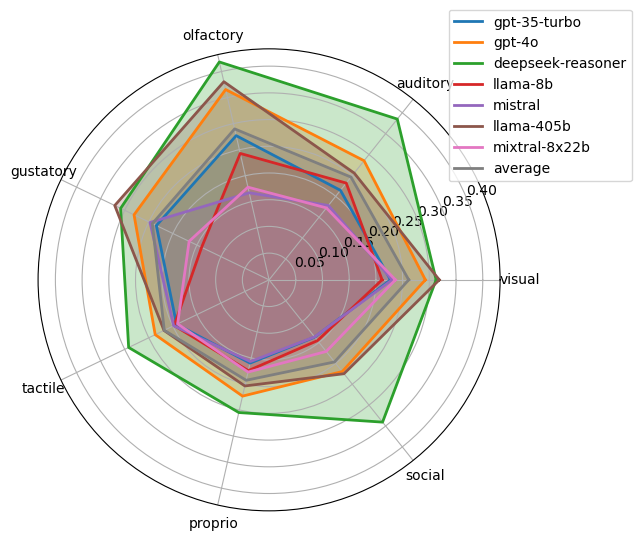

In [118]:
# Senses Interface
import warnings
import matplotlib.pyplot as plt
dataset = 'bigtom'
models = ['gpt-35-turbo', 'gpt-4o', 'deepseek-reasoner', 'llama-8b', 'mistral', 'llama-405b', 'mixtral-8x22b']
task = 'task4'
mode = 'post'
experiment = 'senses'
if task == 'task1' or task == 'task2':
    returned_arr = np.empty((len(models) + 1, num_senses, 5), dtype = float)
else:
    returned_arr = np.empty((len(models) + 1, num_senses, 4), dtype = float)
for i, model in enumerate(models):
    returned = return_metrics(dataset, model, task, mode, experiment) # can collect dictionary too if needed
    # print(json.dumps(returned, indent=4))
    
    if experiment != 'senses':
        print_values(returned)
        print()
    else:
        
        for j, sense in enumerate(senses):
            returned_arr[i][j][0] = returned[sense]['Class-Specific']['Positive']['f1-score']
            returned_arr[i][j][1] = returned[sense]['Class-Specific']['Hard_Negative']['f1-score']
            if task == 'task1' or task == 'task2':
                returned_arr[i][j][2] = returned[sense]['Class-Specific']['Easy_Negative']['f1-score']
                returned_arr[i][j][3] = returned[sense]['Combined']['Total']['accuracy']
                returned_arr[i][j][4] = returned[sense]['Combined']['Total']['macro-f1']
            else:
                returned_arr[i][j][2] = returned[sense]['Combined']['Total']['accuracy']
                returned_arr[i][j][3] = returned[sense]['Combined']['Total']['macro-f1']
                
returned_arr[len(models),:,:] = np.mean(returned_arr[:len(models),:,:], axis = 0)
warnings.filterwarnings(action='once')
np.set_printoptions(suppress=True, precision=3)
data = returned_arr[:,:,3]
print(returned_arr[:,:,3])    
# print(len(models))
num_senses = len(senses)

# Compute angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_senses, endpoint=False).tolist()

# Close the chart
angles += angles[:1]

# Create the figure
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

models.append('average') # for the plot

# Plot each row in the radar chart
for i,row in enumerate(data):
    values = row.tolist()
    values += values[:1]  # Close the radar plot
    ax.plot(angles, values, linewidth=2, linestyle='solid', label = models[i])
    ax.fill(angles, values, alpha=0.25)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(senses)

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

# Show the plot
plt.show()

In [31]:
import csv
data = '''0.832 0.000 0.048 0.714 0.433
0.539 0.021 0.020 0.373 0.280
0.537 0.000 0.000 0.367 0.269
0.593 0.000 0.026 0.424 0.304
0.690 0.010 0.052 0.530 0.360
0.517 0.046 0.080 0.362 0.288
0.436 0.036 0.039 0.288 0.236
0.886 0.299 0.693 0.825 0.754
0.690 0.426 0.817 0.674 0.674
0.656 0.351 0.770 0.640 0.639
0.718 0.347 0.762 0.674 0.666
0.764 0.328 0.736 0.698 0.672
0.596 0.301 0.713 0.546 0.539
0.526 0.457 0.675 0.544 0.543
0.866 0.346 0.699 0.812 0.775
0.753 0.729 0.835 0.791 0.786
0.676 0.585 0.787 0.715 0.711
0.771 0.648 0.816 0.775 0.775
0.784 0.564 0.752 0.759 0.755
0.693 0.692 0.779 0.720 0.718
0.615 0.755 0.806 0.755 0.718
0.782 0.160 0.389 0.678 0.583
0.555 0.383 0.443 0.505 0.498
0.533 0.328 0.473 0.492 0.489
0.605 0.427 0.496 0.564 0.559
0.664 0.346 0.445 0.584 0.559
0.517 0.468 0.504 0.520 0.520
0.424 0.468 0.482 0.470 0.466
0.838 0.160 0.327 0.736 0.567
0.557 0.183 0.283 0.441 0.399
0.544 0.090 0.310 0.425 0.383
0.631 0.179 0.326 0.508 0.448
0.695 0.109 0.361 0.567 0.474
0.534 0.205 0.276 0.421 0.385
0.421 0.295 0.459 0.404 0.403
0.920 0.486 0.832 0.885 0.857
0.735 0.632 0.860 0.763 0.761
0.698 0.545 0.839 0.730 0.727
0.842 0.724 0.915 0.852 0.851
0.780 0.521 0.760 0.749 0.744
0.687 0.676 0.811 0.727 0.722
0.610 0.702 0.820 0.723 0.697
0.862 0.207 0.600 0.787 0.698
0.615 0.353 0.630 0.574 0.569
0.606 0.282 0.617 0.557 0.551
0.712 0.416 0.695 0.661 0.650
0.725 0.248 0.577 0.634 0.588
0.591 0.395 0.563 0.536 0.528
0.487 0.407 0.659 0.514 0.512'''
rows = [line.split() for line in data.split("\n")]

# Write to CSV file
with open("report_output.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(rows)

Task 1

In [6]:
with open(f'opentom_task1_ans_{model}.jsonl') as f: # put story here
    task1_ans = [json.loads(line) for line in f]
print(len(task1_ans))

NameError: name 'model' is not defined

In [59]:
# Supplementary - Template

from pprint import pprint
model = 'deepseek-reasoner'
with open(f'bigtom_task1_ans_{model}.jsonl') as f: # put story here
    task1_ans = [json.loads(line) for line in f]
#task1_ans = list(np.array(task1_ans)[opentom_filter]) # new
    


task1_llm_answer = [instance['llm_answer'] for instance in task1_ans]
task1_true_answer = [np.array(['A', 'B'])[np.array(instance['true_answer'])] for instance in task1_ans]
# bigtom_task1_llm_answer = bigtom_task1_llm_answer[0:50]
# bigtom_task1_true_answer = bigtom_task1_true_answer[0:50]
task1_llm_answer = np.array(task1_llm_answer)
task1_true_answer = np.array(task1_true_answer)

converted_llm_answer_hard = []
converted_true_answer_hard = []
converted_llm_answer_total = []
converted_true_answer_total = []
converted_llm_answer_easy_only = []
converted_true_answer_easy_only = []

# bigtom_task1_accuracy = (bigtom_task1_llm_answer == bigtom_task1_true_answer).mean(axis=1)
# gt_id = {'positive':0, 'hard_negative': 1, 'easy_negative':2}
# bigtom_task1_correct = np.zeros((100, 3, 8)) # groundtruth: pos, hard_neg, easy_neg
# bigtom_task1_total = np.zeros((100, 3, 8))
for idx, instance in enumerate(task1_ans):
    if instance['groundtruth_classification'] == 'positive':
        for i in range(len(instance['llm_answer'])):
            # insert to hard array
            # llm_answer = instance['llm_answer'][i]
            llm_correct = instance['llm_answer'][i] == np.array(['A', 'B'])[np.array(instance['true_answer'])][i]
            converted_true_answer_hard.append(1)
            converted_llm_answer_hard.append(int(llm_correct))
            converted_true_answer_total.append(1)
            converted_llm_answer_total.append(int(llm_correct))
            converted_true_answer_easy_only.append(1)
            converted_llm_answer_easy_only.append(int(llm_correct))
    else: # negative
        for i in range(len(instance['llm_answer'])):
            llm_correct = instance['llm_answer'][i] == np.array(['A', 'B'])[np.array(instance['true_answer'])][i]
            converted_true_answer_total.append(0)
            converted_llm_answer_total.append(1-int(llm_correct))
            if instance['groundtruth_classification'] == 'hard_negative':
                converted_true_answer_hard.append(0)
                converted_llm_answer_hard.append(1-int(llm_correct))
            else:
                converted_true_answer_easy_only.append(0)
                converted_llm_answer_easy_only.append(1-int(llm_correct))

hard_neg_only_report = classification_report(converted_true_answer_hard,converted_llm_answer_hard, digits = 3, output_dict = True)
easy_neg_only_report = classification_report(converted_true_answer_easy_only,converted_llm_answer_easy_only, digits = 3, output_dict = True)
all_neg_report = classification_report(converted_true_answer_total,converted_llm_answer_total, digits = 3, output_dict = True)
return_dict = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in hard_neg_only_report['0'].items() if k != 'support'}, 'Easy_Negative': {k: v for k,v in easy_neg_only_report['0'].items() if k != 'support'}},
               'Combined': {'Positive_and_Hard_Neg_only':{'accuracy':hard_neg_only_report['accuracy'] if hard_neg_only_report['accuracy'] is not None else hard_neg_only_report['micro avg']['f1-score'], 'macro-f1' : hard_neg_only_report['macro avg']['f1-score']},
                            'Total':{'accuracy':all_neg_report['accuracy'] if all_neg_report['accuracy'] is not None else all_neg_report['micro avg']['f1-score'], 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
print(json.dumps(return_dict, indent=4))
print(classification_report(converted_true_answer_total,converted_llm_answer_total, digits = 3))
# Positive: Precision, Recall, F1
# Hard_neg: precision, recall, f1
# easy_neg: precision, recall f1
#positive/hard_neg: accuracy, macrof1
#total: accuracy, macrof1
# print(return_dict)


{
    "Class-Specific": {
        "Positive": {
            "precision": 0.6539130434782608,
            "recall": 0.8374164810690423,
            "f1-score": 0.734375
        },
        "Hard_Negative": {
            "precision": 0.6822633297062024,
            "recall": 0.5741758241758241,
            "f1-score": 0.6235703630034809
        },
        "Easy_Negative": {
            "precision": 0.8279316440777843,
            "recall": 0.809331797235023,
            "f1-score": 0.8185260704922809
        }
    },
    "Combined": {
        "Positive_and_Hard_Neg_only": {
            "accuracy": 0.7378808864265928,
            "macro-f1": 0.7112539730024046
        },
        "Total": {
            "accuracy": 0.7647058823529411,
            "macro-f1": 0.7615974378881989
        }
    }
}
              precision    recall  f1-score   support

           0      0.874     0.719     0.789      2828
           1      0.654     0.837     0.734      1796

    accuracy                        

In [ ]:
# Supplementary
import numpy as np
from sklearn.metrics import classification_report
# model = 'mistral'
# with open(f'bigtom_task1_ans_{model}.jsonl') as f: # ambiguous story
#     bigtom_task1_ans = [json.loads(line) for line in f]
labeller = {0:[0,0,0], 1:[1,0,0], 2:[1,1,0], 3:[1,1,1]}
task1_human_answer = [labeller[round(instance['belief_change_label_raw']*3)] for instance in final_bigtom]
task1_true_answer = [[instance['belief_change_label'], instance['belief_change_label'], instance['belief_change_label']] for instance in final_bigtom]
task1_human_answer = np.array(task1_human_answer)
task1_true_answer = np.array(task1_true_answer)

gt_class = np.array([instance['groundtruth_classification'] for instance in final_bigtom])


print('positives (1) and hard negative (0):\n', classification_report(task1_true_answer[gt_class != 'easy_negative'].reshape(-1),task1_human_answer[gt_class != 'easy_negative'].reshape(-1), digits = 3))
print('positives (1) and easy negative (0):\n', classification_report(task1_true_answer[gt_class != 'hard_negative'].reshape(-1),task1_human_answer[gt_class != 'hard_negative'].reshape(-1), digits = 3))
print('positives (1) and all negative (0):\n', classification_report(task1_true_answer.reshape(-1),task1_human_answer.reshape(-1), digits = 3))


Task 2

In [9]:
# task1_ans

In [36]:
bigtom_filter

array([False,  True,  True, ...,  True,  True,  True])

In [83]:
# Supplementary - Template
import random
import json
import numpy as np

random.seed(0)

from sklearn.metrics import classification_report, precision_recall_fscore_support
model = 'gpt-35-turbo'
with open(f'opentom_task2_ans_{model}.jsonl') as f: # put story here
    task2_ans = [json.loads(line) for line in f]

# task2_ans = list(np.array(task2_ans)[bigtom_filter]) # new
    
letters = {'A':0, 'B':1, 'C':2, 'D':3}

task2_llm_answer = [instance['llm_answer'][:3] for instance in task2_ans]
task2_true_answer = [instance['true_answer'][:3] for instance in task2_ans]
# bigtom_task1_llm_answer = bigtom_task1_llm_answer[0:50]
# bigtom_task1_true_answer = bigtom_task1_true_answer[0:50]
task2_llm_answer = np.array(task2_llm_answer)
task2_true_answer = np.array(task2_true_answer)

converted_llm_answer_hard = []
converted_true_answer_hard = []
converted_llm_answer_total = []
converted_true_answer_total = []
converted_llm_answer_easy_only = []
converted_true_answer_easy_only = []

# bigtom_task1_accuracy = (bigtom_task1_llm_answer == bigtom_task1_true_answer).mean(axis=1)
# gt_id = {'positive':0, 'hard_negative': 1, 'easy_negative':2}
# bigtom_task1_correct = np.zeros((100, 3, 8)) # groundtruth: pos, hard_neg, easy_neg
# bigtom_task1_total = np.zeros((100, 3, 8))
for idx, instance in enumerate(task2_ans):
    for i in range(3):
        true_answer = instance['true_answer_og']
        llm_answer_index = instance['llm_answer'][i]
        if llm_answer_index not in ['A','B','C','D']:
            llm_answer_index = random.choice(['A','B','C','D'])
        llm_answer_index = letters[llm_answer_index]
        llm_answer = instance['answer_order'][i][llm_answer_index]
        converted_true_answer_total.append(true_answer)
        converted_llm_answer_total.append(llm_answer)
        if instance['groundtruth_classification'] == 'positive':
            converted_true_answer_hard.append(true_answer)
            converted_llm_answer_hard.append(llm_answer)
            converted_true_answer_easy_only.append(true_answer)
            converted_llm_answer_easy_only.append(llm_answer)
        else: # negative
            if instance['groundtruth_classification'] == 'hard_negative':
                converted_true_answer_hard.append(true_answer)
                converted_llm_answer_hard.append(llm_answer)
            else:
                converted_true_answer_easy_only.append(true_answer)
                converted_llm_answer_easy_only.append(llm_answer)

print('positives (1) and hard negative (0):\n', classification_report(converted_true_answer_hard,converted_llm_answer_hard, digits = 3,labels=[0,1,2,3]))
print(precision_recall_fscore_support(converted_true_answer_hard, converted_llm_answer_hard, average = 'micro', labels=[0,1,2,3]))
print('positives (1) and easy negative (0):\n', classification_report(converted_true_answer_easy_only,converted_llm_answer_easy_only, digits = 3,labels=[0,1,2,3]))
print(precision_recall_fscore_support(converted_true_answer_easy_only, converted_llm_answer_easy_only, average = 'micro', labels=[0,1,2,3]))
print('positives (1) and all negative (0):\n', classification_report(converted_true_answer_total,converted_llm_answer_total, digits = 3,labels=[0,1,2,3]))
print(precision_recall_fscore_support(converted_true_answer_total, converted_llm_answer_total, average = 'micro', labels=[0,1,2,3]))


positives (1) and hard negative (0):
               precision    recall  f1-score   support

           0      0.747     0.104     0.183       651
           1      0.758     0.978     0.854      1767
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0

   micro avg      0.743     0.743     0.743      2418
   macro avg      0.376     0.271     0.259      2418
weighted avg      0.755     0.743     0.673      2418

(0.7427626137303557, 0.7427626137303557, 0.7427626137303556, None)
positives (1) and easy negative (0):
               precision    recall  f1-score   support

           0      0.827     0.071     0.130      1560
           1      0.640     0.978     0.774      1767
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0

   micro avg      0.552     0.552     0.552      3327
   macro avg      0.367     0.262     0.226      3327
weighted avg      0.728     0.552     0.47

/Users/dkoffical/opt/anaconda3/envs/COMP4222/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkoffical/opt/anaconda3/envs/COMP4222/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkoffical/opt/anaconda3/envs/COMP4222/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [14]:
with open(f'bigtom_task1_ans_{model}.jsonl') as f: # put story here
    bigtom_IDs = np.array([json.loads(line)['ID'] for line in f])
with open(f'opentom_task1_ans_{model}.jsonl') as f: # put story here
    opentom_IDs = np.array([json.loads(line)['ID'] for line in f])

In [21]:
# Supplementary - Template

from sklearn.metrics import classification_report
model = 'deepseek-reasoner'
with open(f'bigtom_task3_ans_{model}.jsonl') as f: # put story here
    task3_ans = [json.loads(line) for line in f]

IDs_after_filter = bigtom_IDs[bigtom_filter]
task3_ans = [instance for instance in task3_ans if instance['ID'] in IDs_after_filter]
task3_llm_answer = [instance['llm_answer'] for instance in task3_ans]
task3_true_answer = [np.array(['A', 'B'])[np.array(instance['true_answer'])] for instance in task3_ans]
# bigtom_task1_llm_answer = bigtom_task1_llm_answer[0:50]
# bigtom_task1_true_answer = bigtom_task1_true_answer[0:50]
task3_llm_answer = np.array(task3_llm_answer)
task3_true_answer = np.array(task3_true_answer)

converted_llm_answer_total = []
converted_true_answer_total = []

# bigtom_task1_accuracy = (bigtom_task1_llm_answer == bigtom_task1_true_answer).mean(axis=1)
# gt_id = {'positive':0, 'hard_negative': 1, 'easy_negative':2}
# bigtom_task1_correct = np.zeros((100, 3, 8)) # groundtruth: pos, hard_neg, easy_neg
# bigtom_task1_total = np.zeros((100, 3, 8))
for idx, instance in enumerate(task3_ans):
    if instance['groundtruth_classification'] == 'positive':
        for i in range(len(instance['llm_answer'])):
            # insert to hard array
            # llm_answer = instance['llm_answer'][i]
            llm_correct = instance['llm_answer'][i] == np.array(['A', 'B'])[np.array(instance['true_answer'])][i]
            converted_true_answer_total.append(1)
            converted_llm_answer_total.append(int(llm_correct))
    else: # negative
        for i in range(len(instance['llm_answer'])):
            llm_correct = instance['llm_answer'][i] == np.array(['A', 'B'])[np.array(instance['true_answer'])][i]
            converted_true_answer_total.append(0)
            converted_llm_answer_total.append(1-int(llm_correct))

all_neg_report = classification_report(converted_true_answer_total,converted_llm_answer_total, digits = 3, output_dict = True)
return_dict = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in all_neg_report['0'].items() if k != 'support'}},
               'Combined': {'Total':{'accuracy':all_neg_report['accuracy'] if all_neg_report['accuracy'] is not None else all_neg_report['micro avg']['f1-score'], 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
print(json.dumps(return_dict, indent=4))

{
    "Class-Specific": {
        "Positive": {
            "precision": 0.7926904176904177,
            "recall": 0.7888141809290954,
            "f1-score": 0.7907475490196079
        },
        "Hard_Negative": {
            "precision": 0.6292918454935622,
            "recall": 0.6347402597402597,
            "f1-score": 0.6320043103448275
        }
    },
    "Combined": {
        "Total": {
            "accuracy": 0.733203125,
            "macro-f1": 0.7113759296822177
        }
    }
}


In [75]:
# Supplementary - Template
import random
import json
import numpy as np
random.seed(0)

from sklearn.metrics import classification_report
model = 'llama-405b'
with open(f'opentom_task4_ans_{model}.jsonl') as f: # put story here
    task4_ans = [json.loads(line) for line in f]
    
letters = {'A':0, 'B':1, 'C':2, 'D':3}

task4_llm_answer = [instance['llm_answer'][:3] + instance['llm_answer'][5:8] for instance in task4_ans]
task4_true_answer = [instance['true_answer'][:3] + instance['true_answer'][5:8] for instance in task4_ans]
# bigtom_task1_llm_answer = bigtom_task1_llm_answer[0:50]
# bigtom_task1_true_answer = bigtom_task1_true_answer[0:50]
task4_llm_answer = np.array(task4_llm_answer)
task4_true_answer = np.array(task4_true_answer)

converted_llm_answer_total = []
converted_true_answer_total = []

# bigtom_task1_accuracy = (bigtom_task1_llm_answer == bigtom_task1_true_answer).mean(axis=1)
# gt_id = {'positive':0, 'hard_negative': 1, 'easy_negative':2}
# bigtom_task1_correct = np.zeros((100, 3, 8)) # groundtruth: pos, hard_neg, easy_neg
# bigtom_task1_total = np.zeros((100, 3, 8))
for idx, instance in enumerate(task4_ans):
    for i in [0,1,2,5,6,7]:
        true_answer = instance['true_answer_og']
        llm_answer_index = instance['llm_answer'][i]
        if llm_answer_index not in ['A','B','C','D']:
            llm_answer_index = random.choice(['A','B','C','D'])
        llm_answer_index = letters[llm_answer_index]
        llm_answer = instance['answer_order'][i][llm_answer_index]
        converted_true_answer_total.append(true_answer)
        converted_llm_answer_total.append(llm_answer)

print('positives (1) and all negative (0):\n', classification_report(converted_true_answer_total,converted_llm_answer_total, digits = 3,labels=[0,1,2,3]))
all_neg_report = classification_report(converted_true_answer_total,converted_llm_answer_total, digits = 3, labels=[0,1,2,3],output_dict = True)
print(json.dumps(all_neg_report, indent = 4))
return_dict = {'Class-Specific': {'Positive': {k: v for k,v in all_neg_report['1'].items() if k != 'support'}, 'Hard_Negative': {k: v for k,v in all_neg_report['0'].items() if k != 'support'}},
               'Combined': {'Total':{'accuracy':float(all_neg_report['accuracy'] if 'accuracy' in all_neg_report.keys() else all_neg_report['micro avg']['f1-score']), 'macro-f1' : all_neg_report['macro avg']['f1-score']}}}
print(json.dumps(return_dict, indent=4))

positives (1) and all negative (0):
               precision    recall  f1-score   support

           0      0.668     0.319     0.432      1302
           1      0.814     0.861     0.837      3534
           2      0.000     0.000     0.000         0
           3      0.000     0.000     0.000         0

   micro avg      0.715     0.715     0.715      4836
   macro avg      0.371     0.295     0.317      4836
weighted avg      0.775     0.715     0.728      4836

{
    "0": {
        "precision": 0.6682769726247987,
        "recall": 0.3187403993855607,
        "f1-score": 0.4316172646905876,
        "support": 1302.0
    },
    "1": {
        "precision": 0.814071696094168,
        "recall": 0.8610639501980758,
        "f1-score": 0.8369086908690868,
        "support": 3534.0
    },
    "2": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 0.0
    },
    "3": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
 

/Users/dkoffical/opt/anaconda3/envs/COMP4222/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkoffical/opt/anaconda3/envs/COMP4222/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dkoffical/opt/anaconda3/envs/COMP4222/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie